In [71]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from dual_aperture import Aperture, Detector, run_model, PlaneWaveDetector, xp, Sample

In [72]:
import ase
import abtem
from abtem.core.energy import energy2wavelength
unit_cell = ase.build.bulk("Au", cubic=True)
atoms = unit_cell * (3, 3, 1)
potential = abtem.Potential(
    atoms,
    slice_thickness=5,
    sampling=0.015,
    projection="infinite",
)
energy_ev = 60e3
wavelength = energy2wavelength(energy_ev) * 1e-10  # m
print(wavelength)
phase_shift = potential.build().compute().transmission_function(energy_ev).compute().array[0]

4.866060479040298e-12
[########################################] | 100% Completed | 100.96 ms


Text(0.5, 1.0, 'phase shift')

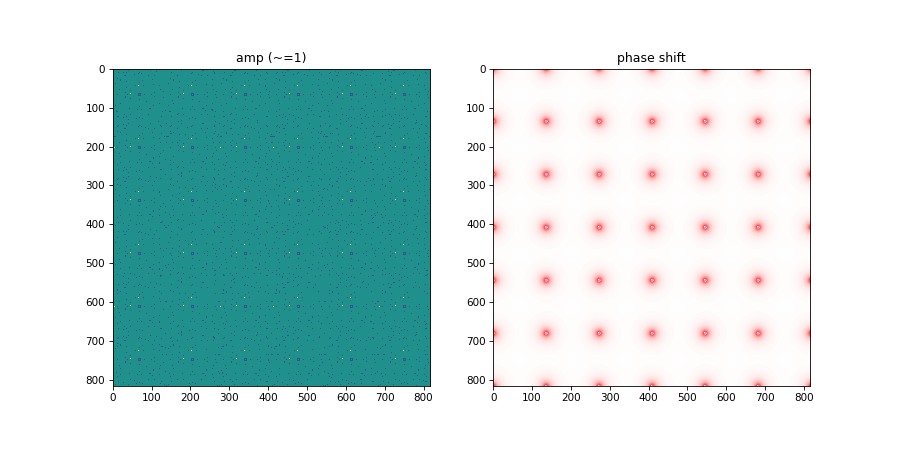

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(np.abs(phase_shift))
ax1.set_title('amp (~=1)')
ax2.imshow(np.angle(phase_shift), cmap='bwr', vmin=-np.pi, vmax=np.pi)
ax2.set_title('phase shift')

[########################################] | 100% Completed | 101.26 ms


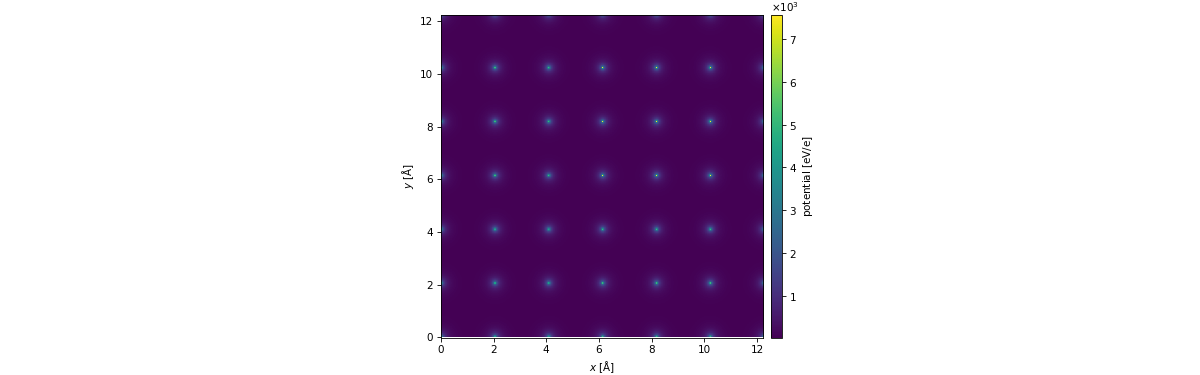

In [74]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [81]:
um = 1e-6
nm = 1e-9

if False:
    intermediate_aperture = Aperture(
        z=2500 * um, radius=100 * um, cyx=None,  #(100 * um, 100 * um)
    )
else:
    intermediate_aperture = None

num_rays = int(1e4)
print(f"wavelength = {wavelength * 1e9} nm")

input_size = (6 * nm, 6 * nm)
det_size = (6 * nm, 6 * nm)

aperture_radius = 1 * nm
aper_z_prop = 10 * nm
det_z_prop = 10 * nm

wavefront = run_model(
    num_rays,
    wavelength,
    Sample(
        z=0 * nm,
        size=input_size,
        illuminated_r= 4 * nm,
        illuminated_cyx=None, # (0.5 * nm, 0.5 * nm),
        phase_shift=xp.asarray(phase_shift),
        periodic=True,
        cutoff=0.5,
    ),
    Aperture(
        z=aper_z_prop, radius=aperture_radius, cyx=None,
    ),
    Detector(
        z=det_z_prop + aper_z_prop, shape=(128, 128), size=det_size
    ),
    batch_size=int(1e3),
)



wavelength = 0.004866060479040298 nm


  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'phase')

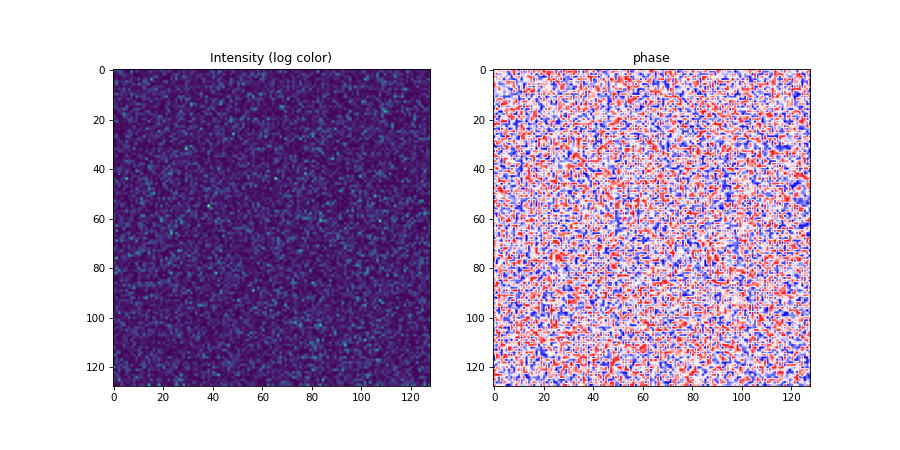

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(np.abs(wavefront) ** 2)
ax1.set_title('Intensity (log color)')
ax2.imshow(np.angle(wavefront), cmap='bwr', vmin=-np.pi, vmax=np.pi)
ax2.set_title('phase')

In [77]:
# from diffractio import um, np
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY

0.0030000000000000005 0.0030000000000000005
816 816


(<Figure size 480x360 with 1 Axes>,
 <Axes: xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7fa9b35a9ed0>)

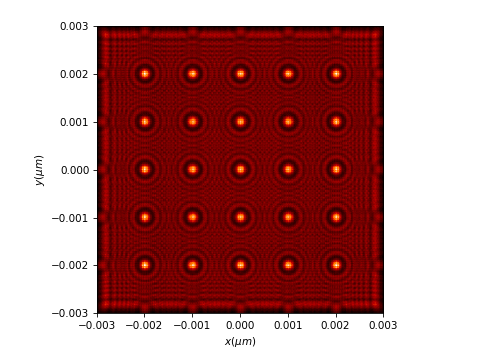

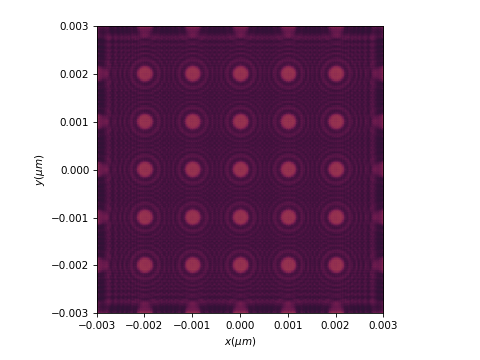

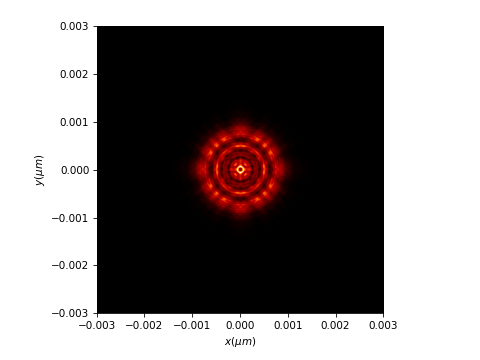

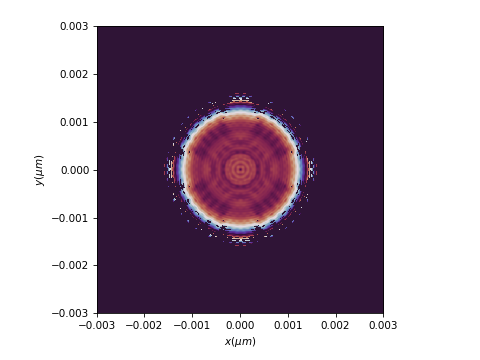

In [78]:
py, px = phase_shift.shape
sy, sx = np.asarray(input_size) / 2. * 1e6

print(sy, sx)
print(py, px)
yv = np.linspace(-sy, sy, num=py, endpoint=True)
xv = np.linspace(-sx, sx, num=px, endpoint=True)

# Make scalar source
u0 = Scalar_source_XY(xv, yv , wavelength * 1e6)
u0.plane_wave(z0=0)

# # Make scalar diffraction mask
t0=Scalar_mask_XY(xv, yv, wavelength * 1e6)
t0.u = np.asarray(phase_shift)
u1=u0 * t0

amplification = (np.array(det_size) / np.array(input_size)).astype(int)

u2 = u1.RS(z=aper_z_prop * 1e6, amplification=amplification, new_field=True, verbose=True)

t1=Scalar_mask_XY(xv, yv, wavelength * 1e6)
t1.circle(r0=(0 * um, 0 * um), radius=(aperture_radius * 1e6, aperture_radius * 1e6), angle=0)

u3 = u2 * t1

u4 = u3.RS(z=(aper_z_prop + det_z_prop) * 1e6, amplification=amplification, new_field=True, verbose=True)

u2.draw(kind='intensity')
u2.draw(kind='phase')
u4.draw(kind='intensity')
u4.draw(kind='phase')

In [79]:
# x_limits = (np.asarray(det_size) - np.asarray(det_size) / 2.) * 1e6
# y_limits = (np.asarray(det_size) - np.asarray(det_size) / 2.) * 1e6
# u2.cut_resample(x_limits=tuple(x_limits),
#                 y_limits=tuple(y_limits),
#                 num_points=(128, 128),
#                 new_field=False)
                
# u2.draw(kind='intensity', logarithm=False)
# u2.draw(kind='phase', logarithm=False)

In [80]:
# # Check aperture sampling is uniform-ish
# points = Aperture(
#     z=0 * um, radius=100 * um, cyx=None,
# ).random_on(5000, np.random.RandomState())
# fig, ax1 = plt.subplots()
# ax1.plot(points[:, 0], points[:, 1], 'rx')
# ax1.axis('equal');